In [2]:
%cd ..
%load_ext autoreload
%autoreload 2

/hdd/aouadt/these/projets/3d_segm


In [3]:
from typing import Tuple
from time import time
import random
from abc import ABC, abstractmethod

from PIL import Image, ImageDraw
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import convolve
import skimage.morphology as morp
import cv2
from tqdm.notebook import tqdm

from deep_morpho.models.bimonn_axspa import BimonnAxspaPipeline, BimonnAxspaFromSegm
from general.utils import set_borders_to
from deep_morpho.datasets.spalike_generator import SpaLike
from deep_morpho.datasets import DataModule
from deep_morpho.models import GenericLightningModel

from deep_morpho.datasets.utils import (
    rand_shape_2d,
    invert_proba,
    get_rect_vertices,
    draw_poly,
    draw_ellipse
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


# Model

In [17]:
# model = BimonnAxspaPipeline()
model = BimonnAxspaFromSegm(bimonn_channels=[7, 7], bimonn_kernel_size=[7, 7, 7])

img = torch.rand(4, 1, 256, 256)
segm = torch.randint(0, 2, size=(4, 2, 256, 256)).float()
otp = model(img, segm)

In [18]:
otp

{'segmentation': tensor([[[[1., 1., 1.,  ..., 0., 1., 0.],
           [0., 1., 0.,  ..., 1., 1., 0.],
           [0., 1., 0.,  ..., 1., 1., 1.],
           ...,
           [0., 0., 1.,  ..., 0., 1., 1.],
           [0., 1., 0.,  ..., 0., 0., 1.],
           [0., 1., 0.,  ..., 1., 1., 1.]],
 
          [[1., 0., 1.,  ..., 0., 0., 0.],
           [1., 0., 0.,  ..., 0., 1., 1.],
           [0., 1., 0.,  ..., 0., 1., 0.],
           ...,
           [1., 0., 0.,  ..., 0., 1., 1.],
           [1., 0., 1.,  ..., 0., 1., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 1., 1.,  ..., 1., 0., 0.],
           [1., 1., 1.,  ..., 0., 1., 1.],
           [1., 1., 1.,  ..., 0., 0., 0.],
           ...,
           [1., 0., 1.,  ..., 1., 1., 0.],
           [0., 1., 1.,  ..., 0., 0., 0.],
           [1., 0., 0.,  ..., 1., 1., 1.]],
 
          [[0., 1., 1.,  ..., 0., 0., 1.],
           [1., 1., 0.,  ..., 0., 0., 1.],
           [1., 1., 1.,  ..., 0., 0., 1.],
           ...,
     

# Dataset and Dataloader

In [4]:
dataset = DataModule.select("spalikedataset")(image_size=(256, 256))

In [6]:
(img, segm), label = dataset[0]
segm.shape

torch.Size([2, 256, 256])

In [7]:
dataloader = DataModule.select("spalikedataset").get_loader(image_size=(256, 256), n_inputs=10000, batch_size=24, num_workers=24)

pbar = tqdm(dataloader, total=len(dataloader))
for batch in dataloader:
    pbar.update(1)

  0%|          | 0/417 [00:00<?, ?it/s]

In [12]:
dataloader = DataModule.select("spalikedataset").get_loader(image_size=(256, 256), n_inputs=10000, batch_size=24, num_workers=24)
model = BimonnAxspaFromSegm(bimonn_channels=[7, 7], bimonn_kernel_size=[7, 7, 7])

model.to(device)

pbar = tqdm(dataloader, total=len(dataloader))
for batch in dataloader:
    (img, segm), label = batch
    img = img.to(device)
    segm = segm.to(device)
    otp = model((img, segm))
    pbar.update(1)

  0%|          | 0/417 [00:00<?, ?it/s]

/hdd/aouadt/these/projets/3d_segm/deep_morpho/models/bisel.py:21: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  m = x // div1


In [11]:
segm.shape

torch.Size([24, 2, 256, 256])

In [1]:
dataloader = DataModule.select("spalikedataset").get_loader(image_size=(256, 256), n_inputs=10000, batch_size=24, num_workers=24)
model = GenericLightningModel.select("LightningBimonnAxspaFromSegm")(
    model_args={
        "bimonn_channels": [7, 7], "bimonn_kernel_size": [7, 7, 7]
    },
    learning_rate=1e-3,
    loss=nn.BCELoss(),
    optimizer=torch.optim.Adam,
)

model.to(device)

pbar = tqdm(dataloader, total=len(dataloader))
for batch in dataloader:
    img, segm, label = batch
    img = img.to(device)
    segm = segm.to(device)
    otp = model((img, segm))
    pbar.update(1)

NameError: name 'DataModule' is not defined

In [29]:
segm.shape

(256, 256, 2)

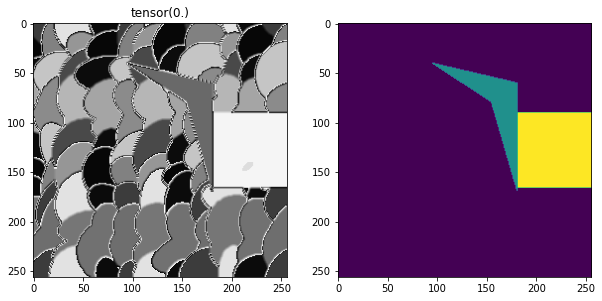

In [44]:
img, segm, tar = next(iter(dataloader))

img = img[0].numpy()
segm = segm[0].permute(1, 2, 0).numpy()

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img, cmap="gray")
plt.title(tar[0])

plt.subplot(122)
to_plot = np.zeros((segm.shape[0], segm.shape[1]))
to_plot[segm[:, :, 0].astype(bool)] = 1
to_plot[segm[:, :, 1].astype(bool)] = 2
plt.imshow(to_plot)

In [21]:
segm.shape

torch.Size([24, 256, 256])

In [23]:
dataloader

In [21]:
next(iter(dataloader))

TypeError: 'str' object cannot be interpreted as an integer

# Spa Like Dataset

In [56]:
%%timeit
dil1 = dilate_cv(img, selem)

18.3 µs ± 52 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [57]:
%%timeit
dil1 = erode_cv(img, selem)

18.5 µs ± 141 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [54]:
%%timeit
dil1 = morp.binary_dilation(img, selem)

606 µs ± 2.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


True
150
218


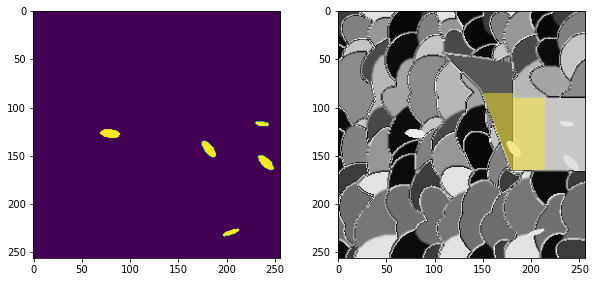

In [26]:
img = np.zeros((256, 256), dtype=np.uint8)



gen = SpaLike((256, 256), proba_lesion=0.5, max_n_blob=5, grid_spacing=(24, 24), max_ellipse_axes=35)
img, segm = gen.generate_image()
roi = gen.roi

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(gen.segmentation_lesion, )

plt.subplot(222)
plt.imshow(img, vmin=0, vmax=255, cmap="gray")
# draw bbox
# (xmin, ymin), (xmax, ymax) = bone_gen.iliac_bbox1
# plt.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], color="red")
# draw roi on a masked plot using masked array
plt.imshow(np.ma.masked_where(roi == 0, roi), vmin=0, vmax=1, alpha=0.5)

print(gen.label)

# plt.subplot(223)
# plt.imshow(gen.zones_init[0])

# plt.subplot(224)
# plt.imshow(gen.zones[0])

print((roi & gen.segmentation_lesion).sum())
print(((~roi & ~gen.iliac_segmentation & ~gen.sacrum_segmentation) & gen.segmentation_lesion).sum())


In [27]:
%%timeit
img, segm = gen.generate_image()


n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 3
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
4.67 ms ± 246 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
gen.texture_generator.grid_spacing

(16, 16)

In [4]:
from deep_morpho.datasets import DiskorectDataset
from deep_morpho.morp_operations import ParallelMorpOperations

disko = DiskorectDataset(morp_operation=ParallelMorpOperations.closing(selem=morp.disk(3)))

In [5]:
%%timeit
disko[0]

1.68 ms ± 34.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [126]:
segm_sac = gen.sacrum_segmentation
segm_ili = gen.iliac_segmentation

(xmin, ymin), (xmax, ymax) = gen.bone_generator.iliac_bbox1
selem_left = np.zeros((1, 2*(ymax - ymin)))
selem_left[0, :ymax - ymin] = 1
dil_sac = morp.binary_dilation(segm_sac, selem_left)
dil_ili = morp.binary_dilation(segm_ili, selem_left[:, ::-1])

ili_roi = dil_sac & segm_ili
ili_roi = morp.binary_dilation(ili_roi, morp.disk(3)) & segm_ili

sac_roi = dil_ili & segm_sac

final_roi = ili_roi | sac_roi

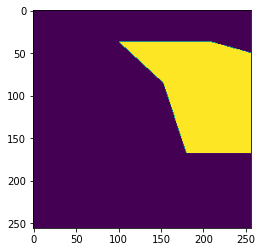

In [127]:
plt.imshow(dil_ili)

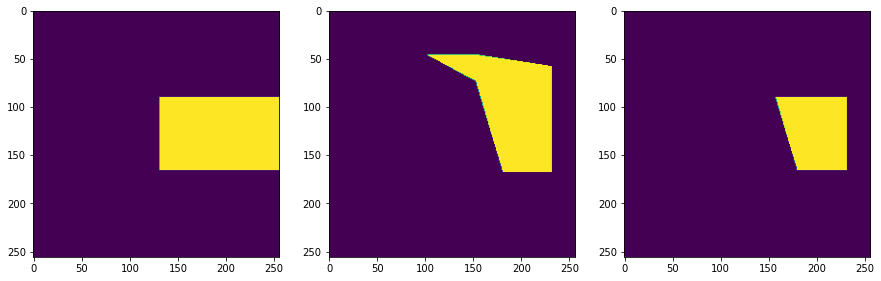

In [25]:
sac = bone_gen.sacrum_segmentation
ili = bone_gen.iliac_segmentation

selem_right = np.array([[0, 1, 1]])
selem_left = np.array([[1, 1, 0]])

def dilate_right(img: np.ndarray, n: int = 1) -> np.ndarray:
    for _ in range(n):
        img = morp.dilation(img, selem_right)
    return img

def dilate_left(img: np.ndarray, n: int = 1) -> np.ndarray:
    for _ in range(n):
        img = morp.dilation(img, selem_left)
    return img

dil_sac = dilate_right(sac, 50)
dil_ili = dilate_left(ili, 50)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(dil_sac)

plt.subplot(132)
plt.imshow(dil_ili)
# plt.imshow(ili)

plt.subplot(133)
plt.imshow(dil_sac * dil_ili)

In [265]:
import cv2
import numpy as np
import random

# Set parameters for your toy dataset
image_size = (256, 256)  # Adjust the size as needed
triangle_size = (32, 32)  # Size of the triangle representing the joint
num_samples = 100  # Number of samples
grid_spacing = 16  # Spacing between ellipses
num_ellipses = 100  # Number of random ellipses
min_ellipse_axes = 13  # Minimum size of ellipse axes
max_ellipse_axes = 18  # Maximum size of ellipse axes
num_colors = 3  # Number of random colors for ellipses


# sinusoidal grid
def sin_grid(x, y, period=(1, 1), offset=(0, 0)):
    def f(x, p):
        return (np.sin(x * 2 * np.pi / p) + 1) / 2 + 1
    return f(x - offset[0], period[0]) * f(y - offset[1], period[1]) + 3


def normalize(x, minv, maxv, min_output_value=0):
    # print(maxv, minv)
    return (x - minv) / (maxv - minv) * (255 - min_output_value) + min_output_value

def generate_synthetic_image(period, offset=(1, 2)):
    # Create a blank image with a grid of ellipses as texture
    background = np.zeros((image_size[0], image_size[1]), dtype=np.uint8)
    
    # Define the position of the triangle within the image
    x = random.randint(0, image_size[0] - triangle_size[0])
    y = random.randint(0, image_size[1] - triangle_size[1])

    # Draw a triangle to represent the joint
    triangle_color = (255, 255, 255)  # White triangle
    triangle = np.array([[x, y], [x + triangle_size[0], y], [x + triangle_size[0] // 2, y + triangle_size[1]]], np.int32)

    # Add information for classification within the triangle
    classification_info = random.choice([0, 1])  # 0 for no inflammation, 1 for inflammation

    # Randomly generate ellipses with different shapes and colors in a grid
    Xs = np.linspace(0, image_size[0], num=int(image_size[0] / grid_spacing) + 1, dtype=np.int32)
    Ys = np.linspace(0, image_size[1], num=int(image_size[1] / grid_spacing) + 1, dtype=np.int32)
    
    # values = sin_grid(np.array(image_size) + 1)

    for idx_x, center_x in enumerate(Xs):
        for idx_y, center_y in enumerate(Ys):
            ellipse_axes = (random.randint(min_ellipse_axes, max_ellipse_axes), random.randint(min_ellipse_axes, max_ellipse_axes))
            angle = random.uniform(0, 360)  # Random rotation angle
            # ellipse_color = random.randint(0, 255)
            ellipse_color = normalize(sin_grid(idx_x + 1, idx_y + 1, period=period, offset=offset), minv=3, maxv=7)
            
            # Draw the random ellipse
            cv2.ellipse(background, (center_x, center_y), ellipse_axes, angle, 0, 360, ellipse_color, -1)

    triangle = np.array([[x, y], [x + triangle_size[0], y], [x + triangle_size[0] // 2, y + triangle_size[1]]], np.int32)
    cv2.fillPoly(background, [triangle], random.randint(64, 170))
    return background, classification_info

4.809161060780646
5.25
5.690838939219354
5.963292387221365
5.963292387221365
5.690838939219355
5.25
4.809161060780646
4.536707612778635
4.536707612778635
4.809161060780645
5.25
5.690838939219354
5.963292387221365
5.963292387221365
5.690838939219355
5.25
5.331420873505193
5.899519052838329
6.467617232171466
6.818721215946278
6.818721215946278
6.467617232171467
5.899519052838329
5.331420873505193
4.980316889730381
4.980316889730381
5.331420873505192
5.899519052838329
6.467617232171465
6.818721215946278
6.818721215946278
6.467617232171467
5.899519052838329
4.286901248056099
4.600480947161671
4.914060646267244
5.107863558496454
5.107863558496454
4.914060646267244
4.600480947161671
4.286901248056099
4.093098335826889
4.093098335826889
4.286901248056098
4.600480947161671
4.914060646267243
5.107863558496454
5.107863558496454
4.914060646267244
4.600480947161671
4.809161060780646
5.25
5.690838939219354
5.963292387221365
5.963292387221365
5.690838939219355
5.25
4.809161060780646
4.53670761277863

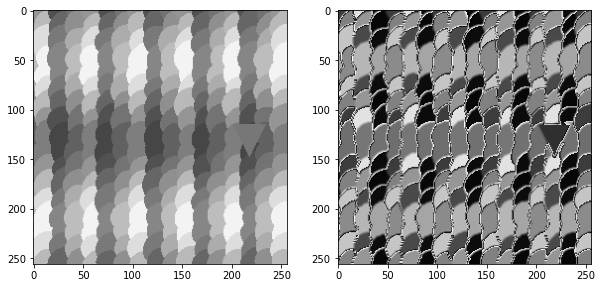

In [266]:
img, label = generate_synthetic_image(period=(3, 10))
# img += np.random.randint(0, 10, img.shape, dtype=np.uint8)
# img, label = generate_synthetic_image(period=(10, 3))
# convolve the img
fimg = convolve(img, np.ones((3, 3)))
# fimg = convolve(img, morp.disk(3))

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img, vmin=0, vmax=255, cmap="gray")

plt.subplot(122)
plt.imshow(fimg, vmin=0, vmax=255, cmap="gray")

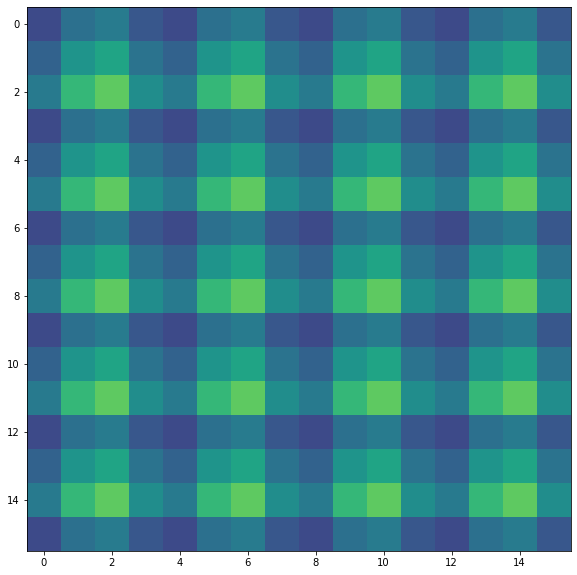

In [166]:
# sinusoidal grid
def sin_grid(x, y, period=(1, 1), offset=(0, 0)):
    def f(x, p):
        return (np.sin(x * 2 * np.pi / p) + 1) / 2 + 1
    return f(x - offset[0], period[0]) * f(y - offset[1], period[1])

XX, YY = np.meshgrid(np.arange(16), np.arange(16))
ZZ = sin_grid(XX, YY, period=(4, 3), offset=[.7, 1])

plt.figure(figsize=(10, 10))
plt.imshow(ZZ, vmin=0, vmax=5,)


In [231]:
%%timeit 
img, label = generate_synthetic_image()


2.96 ms ± 16 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
